# Project: Predicting Boston House Prices with Regression

## Objective
In this project, we will develop an ML model that predicts the monetary value of a house located in Boston. 

## Business Value
A model like this would be valuable for a real estate agent to better serve their clients with selling and purchasing. 

## Data Source
The dataset used comes from the UCI ML Repository. 

## Features
- RM: Average number of rooms 
- LSTAT: Percentage lower status of the population
- PTRATIO: Pupil-teacher ratio by town

## Target
- MEDV: Median value of owner occupied homes in $1000s

### Load Libraries

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling

### Load Dataset

In [2]:
data = pd.read_csv("Datasets/housing.csv")

In [3]:
data.profile_report()

### Extract features and target

In [4]:
prices = data['MEDV']
features = data.drop('MEDV', axis=1)

### Exploratory Data Analysis 
#### Scatterplot and Histograms

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

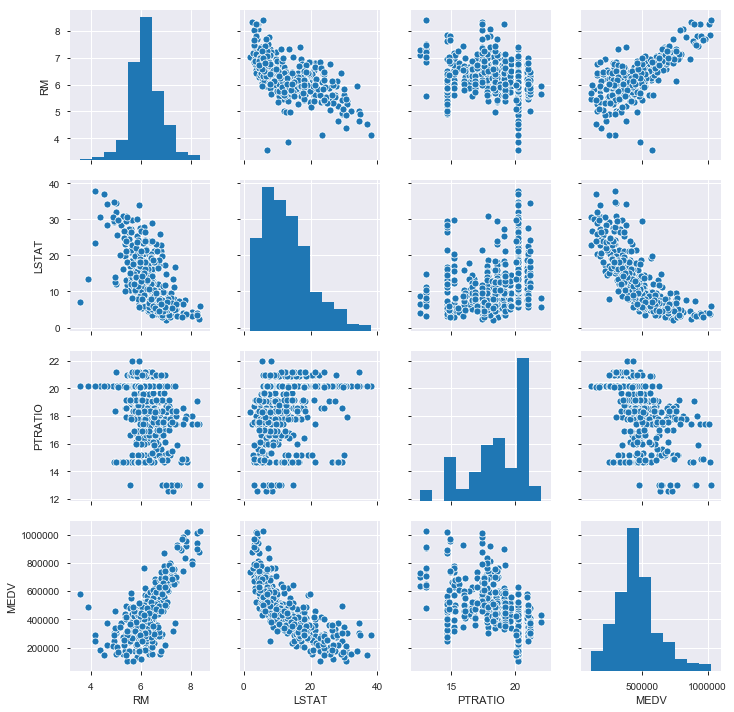

In [6]:
sns.pairplot(data, size = 2.5);

We can spot a linear relationship between ``RM`` and ``MEDV``. 

#### Correlation Matrix

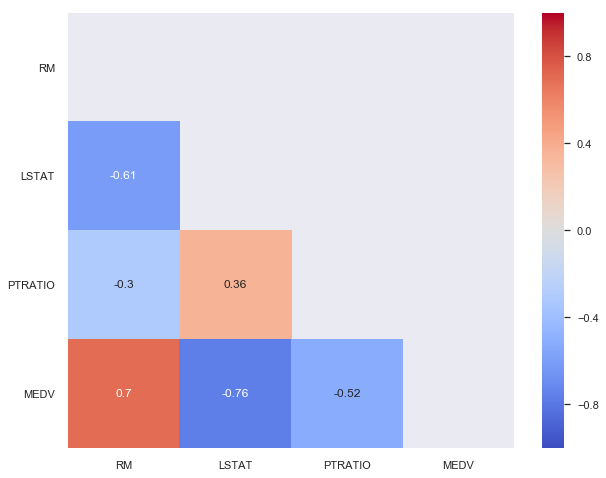

In [12]:
plt.rcParams['figure.figsize'] = [10,8]
# Remove redundant correlations
mask = np.zeros(data.corr().shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(data.corr(), 
            annot=True, 
            vmin=-1, #scale of color palette
            vmax=1, 
            center=0,
           cmap='coolwarm', # color palette
           mask = mask # getting rid of redundant correlations
           )
plt.yticks(rotation=0);

### Developing a Model

#### Determine a Performance Metric
For this project, we will calculate the *coefficient of determination, R^2*
The coefficient of determination is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

#### Import ``r2_score``

In [13]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_value) and predicted (y_predict) values based on
        the metric chosen.
    """
    
    score = r2_score(y_true, y_predict)
    return score

#### Shuffle and Split the Data

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    prices,
    test_size=0.2,
    random_state=42
)

In [17]:
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X,y):
    """
        Performs grid search over the 'max_depth' parameter for a decision
        tree regressor trained on the input data [X,y].
    """
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
    
    # Create decision tree
    regressor = DecisionTreeRegressor()
    
    # Create a dictionary for the parameter 'max_depth' with a range 1-10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    
    # Transform 'performance_metric' into a scoring function
    scoring_function = make_scorer(performance_metric)
    
    # Create the grif search cv object --> GridSearchCV()
    grid = GridSearchCV(estimator = regressor, 
                        param_grid=params, 
                        scoring=scoring_function, 
                        cv=cv_sets)
    
    # Fit the grid search object to the data to compute the optimal model 
    grid = grid.fit(X,y)
    
    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Find the Optimal Model

In [18]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
reg.get_params()['max_depth']

4

Therefore, **4 is the optimal ``max_depth`` for the ML model**.

### Predicting Selling Prices
Now we can put our model to use. Imagine we were given the following data for three clients. 

Feature | Client 1 | Client 2 | Client 3
--------- |-------|-----------|---------|
Total Number of rooms in home|5|4|8
Neighbourhood Poverty Level| 17%|32%|3%
Student-teacher ratio | 15:1|22:1|12:1

**What price would we recommend each client sell his/her home at?**

**Do these prices seem reasonable given the values for the respective features?**

Let's find out.

In [27]:
# Produce matrix for client data
client_data = [
    [5,17,15],
    [4,32,22],
    [8,3,12]
]

# Show predictions
for clientNumber, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client{}: ${:,.2f}"
          .format(clientNumber+1, price))

Predicted selling price for Client1: $403,025.00
Predicted selling price for Client2: $237,478.72
Predicted selling price for Client3: $931,636.36


### Analyzing our Results

Recall our stats from our data analysis:

- Minimum price: $105000.0
- Maximum price: $1024800.0
- Mean price: $454342.944
- Median price $438900.0
- Standard deviation of prices: $165340.277

Client 3: 
- near million dollars, which is near maximum of the dataset. 
- reasonable cause of its features (8 rooms, low poverty level and student-teacher ratio)
- this house is most likely in a wealthy neighbourhood

Client 2: 
- Lowest price of the three clients, reasonably so

Client 1:
- features are intermediate between clients 2 and 3, so it's pricing is near the median/mean
- reasonable